# This notebook looks into the cell heterogeneity in the control treatments

In [1]:
import itertools
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import toml
import umap

%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

/projects/mlippincott@xsede.org/software/anaconda/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/mlippincott@xsede.org/software/anaconda/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/pro

/projects/mlippincott@xsede.org/software/anaconda/envs/Interstellar/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [2]:
# Parameters
cell_type = "PBMC"

In [3]:
# read in toml file

# set up the path
toml_path = pathlib.Path("./utils/params.toml")
# read in the toml file
params = toml.load(toml_path)
list_of_treatments = params["list_of_treatments"]["treatments"]
print(len(list_of_treatments))
print(list_of_treatments)

12
['DMSO__0.100__DMSO__0.025', 'Thapsigargin__1.000__DMSO__0.025', 'Thapsigargin__10.000__DMSO__0.025', 'H2O2__100.000__DMSO__0.025', 'Flagellin__0.100__DMSO__0.025', 'Flagellin__1.000__DMSO__0.025', 'LPS__0.010__DMSO__0.025', 'LPS_Nigericin__1.000_1.0__DMSO__0.025', 'LPS__1.000__DMSO__0.025', 'LPS_Nigericin__1.000_3.0__DMSO__0.025', 'LPS_Nigericin__1.000_10.0__DMSO__0.025', 'LPS__100.000__DMSO__0.025']


In [4]:
# Set path to parquet file
path = pathlib.Path(f"../data/{cell_type}_preprocessed_sc_norm.parquet")
# Read in parquet file
df = pq.read_table(path).to_pandas()
df

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrPM_3_01_256,Nuclei_Texture_Variance_CorrER_3_00_256,Nuclei_Texture_Variance_CorrGasdermin_3_00_256,Metadata_Treatment,Metadata_Dose,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,twob_Metadata_Treatment_Dose_Inhibitor_Dose,threeb_Metadata_Treatment_Dose_Inhibitor_Dose,fourb_Metadata_Treatment_Dose_Inhibitor_Dose
0,PBMC,B02,34618,6,DMSO,0.025,%,LPS,0.01,µg_per_ml,...,0.108250,-0.068544,-0.205295,-0.197257,LPS,0.010,LPS_0.010_DMSO_0.025,LPS_DMSO_0.025__0.010,LPS__0.010__DMSO_0.025,LPS__0.010__DMSO__0.025
1,PBMC,B02,34618,6,DMSO,0.025,%,LPS,0.01,µg_per_ml,...,-0.929131,-0.158906,-0.198572,-0.185623,LPS,0.010,LPS_0.010_DMSO_0.025,LPS_DMSO_0.025__0.010,LPS__0.010__DMSO_0.025,LPS__0.010__DMSO__0.025
2,PBMC,B02,34618,6,DMSO,0.025,%,LPS,0.01,µg_per_ml,...,-1.227278,-0.163521,-0.165140,-0.174762,LPS,0.010,LPS_0.010_DMSO_0.025,LPS_DMSO_0.025__0.010,LPS__0.010__DMSO_0.025,LPS__0.010__DMSO__0.025
3,PBMC,B02,34618,6,DMSO,0.025,%,LPS,0.01,µg_per_ml,...,2.153910,0.586555,0.258023,0.218118,LPS,0.010,LPS_0.010_DMSO_0.025,LPS_DMSO_0.025__0.010,LPS__0.010__DMSO_0.025,LPS__0.010__DMSO__0.025
4,PBMC,B02,34618,6,DMSO,0.025,%,LPS,0.01,µg_per_ml,...,-0.557309,-0.148980,-0.122860,-0.110851,LPS,0.010,LPS_0.010_DMSO_0.025,LPS_DMSO_0.025__0.010,LPS__0.010__DMSO_0.025,LPS__0.010__DMSO__0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5598677,PBMC,O12,29822,6,DMSO,1.000,%,DMSO,0.10,%,...,-0.376617,-0.030944,-0.203394,-0.206115,DMSO,0.100,DMSO_0.100_DMSO_1.0,DMSO_DMSO_1.0__0.100,DMSO__0.100__DMSO_1.0,DMSO__0.100__DMSO__1.0
5598678,PBMC,O12,29822,6,DMSO,1.000,%,DMSO,0.10,%,...,-0.120779,-0.114803,-0.204566,-0.186447,DMSO,0.100,DMSO_0.100_DMSO_1.0,DMSO_DMSO_1.0__0.100,DMSO__0.100__DMSO_1.0,DMSO__0.100__DMSO__1.0
5598679,PBMC,O12,29822,6,DMSO,1.000,%,DMSO,0.10,%,...,-0.291924,-0.141514,-0.188326,-0.173827,DMSO,0.100,DMSO_0.100_DMSO_1.0,DMSO_DMSO_1.0__0.100,DMSO__0.100__DMSO_1.0,DMSO__0.100__DMSO__1.0
5598680,PBMC,O12,29822,6,DMSO,1.000,%,DMSO,0.10,%,...,0.473149,-0.077816,-0.166199,-0.156101,DMSO,0.100,DMSO_0.100_DMSO_1.0,DMSO_DMSO_1.0__0.100,DMSO__0.100__DMSO_1.0,DMSO__0.100__DMSO__1.0


In [5]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
# subset the df for the control
df = df[df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == "DMSO_0.100_DMSO_0.025"]
df

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrPM_3_01_256,Nuclei_Texture_Variance_CorrER_3_00_256,Nuclei_Texture_Variance_CorrGasdermin_3_00_256,Metadata_Treatment,Metadata_Dose,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,twob_Metadata_Treatment_Dose_Inhibitor_Dose,threeb_Metadata_Treatment_Dose_Inhibitor_Dose,fourb_Metadata_Treatment_Dose_Inhibitor_Dose
315708,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.1,%,...,-0.299580,-0.137086,-0.111979,-0.115607,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
315709,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.1,%,...,-0.906742,-0.156287,-0.171005,-0.161728,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
315710,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.1,%,...,-0.392149,-0.146205,-0.169050,-0.166613,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
315711,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.1,%,...,-1.128252,-0.162255,-0.170928,-0.155808,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
315712,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.1,%,...,-0.815351,-0.142273,-0.192711,-0.194270,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555691,PBMC,J07,29315,6,DMSO,0.025,%,DMSO,0.1,%,...,0.081205,-0.116326,-0.194867,-0.181788,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
3555692,PBMC,J07,29315,6,DMSO,0.025,%,DMSO,0.1,%,...,1.855869,0.493227,-0.105125,-0.068579,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
3555693,PBMC,J07,29315,6,DMSO,0.025,%,DMSO,0.1,%,...,-0.060551,-0.116721,-0.198838,-0.181509,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
3555694,PBMC,J07,29315,6,DMSO,0.025,%,DMSO,0.1,%,...,1.742261,0.675294,0.041459,0.213104,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025


In [6]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [7]:
# set umap parameters
umap_params = umap.UMAP(
    n_components=2,
    spread=1.1,
    random_state=0,
    n_neighbors=6,
    min_dist=0.8,
    metric="cosine",
)

In [8]:
# fit and transform data for umap
proj_2d = umap_params.fit_transform(df_values)

# add umap coordinates to dataframe of metadata and raw data
df_values["umap_1"] = proj_2d[:, 0]
df_values["umap_2"] = proj_2d[:, 1]

In [9]:
df_values["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df_descriptive[
    "fourb_Metadata_Treatment_Dose_Inhibitor_Dose"
]
df_values["Metadata_Well"] = df_descriptive["Metadata_Well"]

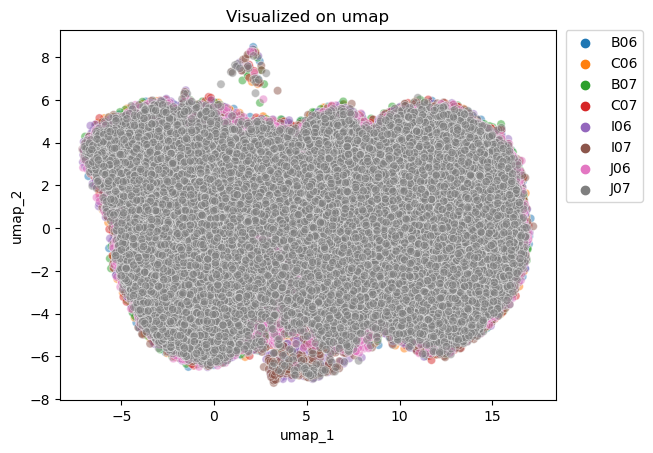

In [10]:
# Figure Showing UMAP of Clusters vs Treatment
sns.scatterplot(
    data=df_values,
    x="umap_1",
    y="umap_2",
    hue="Metadata_Well",
    legend="full",
    alpha=0.5,
)
# add contour lines to the plot

plt.title("Visualized on umap")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

# if path does not exist create it
plt.savefig(
    f"Figures/umap_plate2/cell_heterogeneity_{cell_type}_umap.png", bbox_inches="tight"
)